In [1]:
import os

from ml.eval import eval_model

print(os.getcwd())
os.chdir('/home/jelinek/recetox/')

from ml.pipeline import FeitDataPipeline

from tensorflow import keras

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import concatenate

from cfg import *

from livelossplot import PlotLossesKerasTF

name = "MySimpleCnn_Feit-inception-v2-reduced-skip-connections"


/home/jelinek/recetox/histoseg/notebooks/Residual


In [2]:
class MySimpleCNNInceptionModule(FeitDataPipeline):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.model = self.get_compiled_model()
        self.params.name = name
        self.params.epochs = 200
        self.batch_size = 16
        self.params.tile_size=256

    @staticmethod
    def get_inception_module_dim_reduction(prev_layer, filters_1, filters_2):
        c11 = keras.layers.Conv2D(filters=filters_1, kernel_size=(1,1), padding='same')(prev_layer)
        c12 = keras.layers.Conv2D(filters=filters_2, kernel_size=(1,1), padding='same')(prev_layer)
        c13 = keras.layers.Conv2D(filters=filters_1, kernel_size=(1,1), padding='same')(prev_layer)
        p1 = keras.layers.MaxPooling2D(padding='same', strides=(1,1), pool_size=(3,3))(prev_layer)

        c21 = keras.layers.Conv2D(filters=filters_2, kernel_size=(3,3), padding='same')(c12)
        c22 = keras.layers.Conv2D(filters=filters_2, kernel_size=(5,5), padding='same')(c13)
        c23 = keras.layers.Conv2D(filters=filters_2, kernel_size=(1,1), padding='same')(p1)

        output_layer = concatenate([c11, c21, c22, c23], axis=-1)

        return output_layer

    @staticmethod
    def get_compiled_model():
        inputs = keras.Input(shape=(256, 256, 3))

        x1 = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(inputs,
                                                filters_1=4,
                                                filters_2=4)

        x1 = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x1)
        x1 = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x1)

        x2 = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(x1,
                                                filters_1=8,
                                                filters_2=8)
        x2 = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x2)
        x2 = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x2)

        x1_padded = keras.layers.Conv2D(filters=32, kernel_size=1, strides=(2, 2))(x1)
        x1_padded = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x1_padded)

        add1 = keras.layers.Add()([x2, x1_padded])


        x3 = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(add1,
                                                filters_1=16,
                                                filters_2=16)
        x3 = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x3)
        x3 = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x3)

        add1_padded = keras.layers.Conv2D(filters=64, kernel_size=1, strides=(2, 2))(add1)
        add1_padded = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(add1_padded)

        add2 = keras.layers.Add()([add1_padded, x3])

        x4 = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(add2,
                                                filters_1=32,
                                                filters_2=32)
        x4 = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x4)
        x4 = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x4)

        add2_padded = keras.layers.Conv2D(filters=128, kernel_size=1, strides=(2, 2))(x3)
        add2_padded = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(add2_padded)

        add3 = keras.layers.Add()([x4, add2_padded])

        x5 = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(add3,
                                                filters_1=64,
                                                filters_2=64)
        x5 = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x5)
        x5 = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x5)

        add3_padded = keras.layers.Conv2D(filters=256, kernel_size=1, strides=(2, 2))(add3)
        add3_padded = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(add3_padded)

        add4 = keras.layers.Add()([x5, add3_padded])

        x6 = MySimpleCNNInceptionModule.get_inception_module_dim_reduction(add4,
                                                filters_1=128,
                                                filters_2=128)

        x6 = keras.layers.MaxPooling2D(padding='same', pool_size=(2, 2))(x6)
        x6 = keras.layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x6)

        x = keras.layers.Flatten()(x6)
        outputs = keras.layers.Dense(units=12, activation='softmax')(x)

        model = keras.Model(inputs, outputs, name='MySimpleCnnFewerLayers')
        model.summary()

        file_name = name + '.png'
        keras.utils.plot_model(
        model,
        to_file=file_name,)
        return model

    def _train_model(self, data_train, data_valid):

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=30, min_lr=1e-4, verbose=1,
                                      cooldown=20)

        self.model.fit(data_train,
                       steps_per_epoch=250,
                       epochs=200,
                       shuffle=True,
                       validation_data=data_valid,
                       validation_freq=10,
                       verbose=1,
                       callbacks=[self.tensorboard, reduce_lr, PlotLossesKerasTF()])

In [3]:
pipeline = MySimpleCNNInceptionModule(train_data_dir='data/Feit_colon-annotation-tiles-256/data_train/',
                        valid_data_dir='data/Feit_colon-annotation-tiles-256/data_valid/')

2022-03-13 16:50:53.556119: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 16:50:53.556411: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.65GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-03-13 16:50:53.556473: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-03-13 16:50:53.560508: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-03-13 16:50:53.560607: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-03-13 16:50:53.588925: I tensorflow/stream_exec

Model: "MySimpleCnnFewerLayers"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 4)  16          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 4)  16          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 3)  0           input_1[0][0]                    
_____________________________________________________________________________

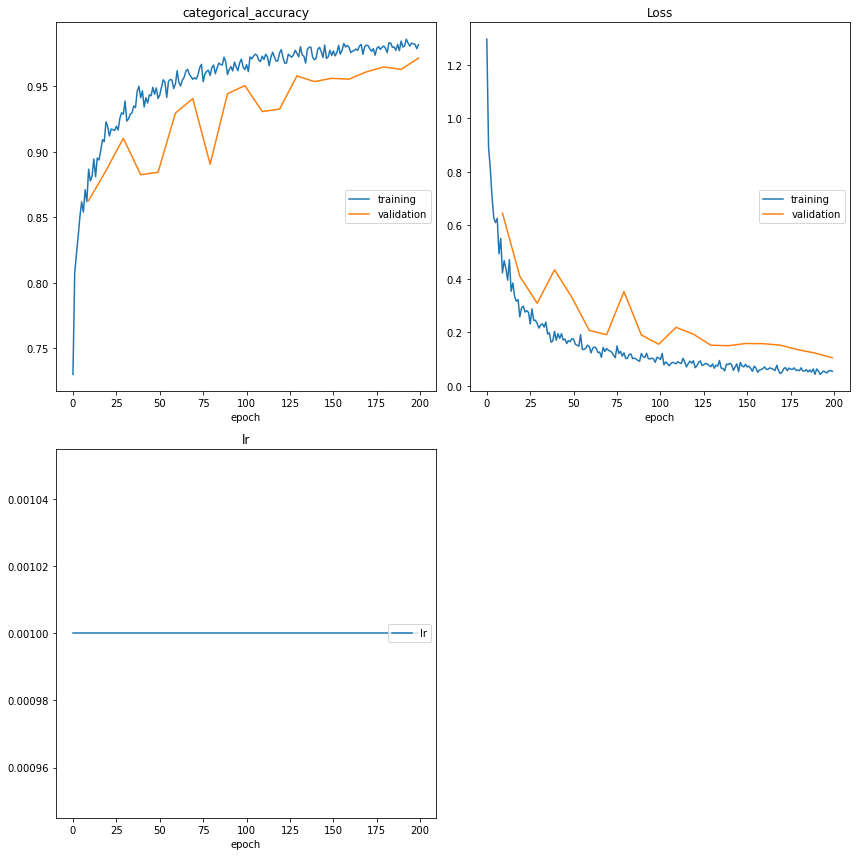

categorical_accuracy
	training         	 (min:    0.730, max:    0.986, cur:    0.982)
	validation       	 (min:    0.863, max:    0.972, cur:    0.972)
Loss
	training         	 (min:    0.043, max:    1.297, cur:    0.055)
	validation       	 (min:    0.105, max:    0.646, cur:    0.105)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
102/102 [==============================] - 5s 49ms/step - loss: 0.1055 - categorical_accuracy: 0.9716
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.4954ms
Confusion Matrix
[[319   0   2   1   2   1   1   0   0   0   5   4]
 [  1  52   6   0   1   0   0   4   0   0   0   0]
 [  1   1 141   0   0   0   0   2   0   0   0   0]
 [  0   0   0  11   0   0   0   0   0   0   0   0]
 [  1   0   0   2 541   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0]
 [  0   2   0   0   0   0  75   0   0   0   0   0]
 [  0   0   0   0   0   0   1  85   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0 

In [4]:
pipeline.execute_pipeline(perform_validation=True, perform_test_segmentation=False)

In [5]:
pipeline.save_pipeline()

/home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [6]:
eval_model(pipeline.model,
           pipeline.get_data_loader_validation(),
           print_confusion_matrix=True,
           save_misclassified=True)

Found 1617 images belonging to 12 classes.
102/102 [==============================] - 5s 49ms/step - loss: 0.1055 - categorical_accuracy: 0.9716
Measuring time
--Iteration 10/10
Batch size: 16
Mean time per tile 0.4215ms
Confusion Matrix
[[319   0   2   1   2   1   1   0   0   0   5   4]
 [  1  52   6   0   1   0   0   4   0   0   0   0]
 [  1   1 141   0   0   0   0   2   0   0   0   0]
 [  0   0   0  11   0   0   0   0   0   0   0   0]
 [  1   0   0   2 541   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0]
 [  0   2   0   0   0   0  75   0   0   0   0   0]
 [  0   0   0   0   0   0   1  85   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0]
 [  5   0   0   0   0   0   0   0   0   0 228   1]
 [  0   0   0   0   0   0   0   0   0   0   0 118]]
Classification Report
                             precision    recall  f1-score   support

             adenocarcinoma       0.98      0.95      0.9

In [3]:
pipeline = FeitDataPipeline.load_pipeline(pipeline_name=name)
pipeline.params.number_of_classes = 12
pipeline.params.class_to_color_mapping =     class_to_color_mapping = [
        'Purple',  # adenocarcinoma
        'Red',  # blood_and_vessels
        'silver',  # connective_tissue
        'White',  # empty
        'thistle',  # fat
        'magenta',  # inflammation_purulent
        'steelblue',  # muscle_cross_section
        'dodgerblue',  # muscle_longitudinal_section
        'darkred',  # necrosis
        'gold',  # nerve
        'seagreen',  # normal_mucosa
        'White'  # unknown
    ]
pipeline.params.class_names=sorted(list(selected_classes_feit.union( {'unknown'} )))

2022-05-14 02:29:38.964833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-14 02:29:39.010849: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-14 02:29:39.011061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-14 02:29:39.011636: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [6]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / pipeline.params.name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         32, pipeline.params.class_names,
                                         save_segmentations=True, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=1, include_unknown=True)

Processing region 120 out of 120
Post-processing image...
Processing grid point 663499 out of 663499
Processing image took 2099.411477804184 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-inception-v2-reduced-skip-connections/ns-adenoca-colon-15071-2019-20x-he-4.tiff
----------------------------------------------------
Processing region 255 out of 255
Post-processing image...
Processing grid point 1599360 out of 1599360
Processing image took 5104.388386726379 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-inception-v2-reduced-skip-connections/ns-adenoca-colon-15072-2019-20x-he-a2.tiff
----------------------------------------------------
Processing region 255 out of 255
Post-processing image...
Processing grid point 1544036 out of 1544036
Processing image took 4948.103069067001 seconds
Saving file...
File saved to segmentations/MySimpleCnn_Feit-inception-v2-reduced-skip-connections/ns-adenoca-colon-3043-2019-20x-he-a1.tiff
----------------------